# Bootstrapping for each replicate

## Data analysis: Linear model fit and volume corrected moments

In [1]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures

In [2]:
df = DataFrame(CSV.File("FISH_toShare_NoTSlabel_celldata_long_220620_simple_woMad3Outlier_withColDescription.csv"));

In [3]:
names(df);

In [4]:
df = df[:,[:sampleID,:gene,:NucleiCount,:Compartment,:CountMethod,:RNAperCell,:Cell_Length_um]];

In [5]:
# filter only for mad1WTGFP and NucleiCount = 1
dfa = subset(df, :gene => g -> g.=="mad1WTymEGFP", :NucleiCount => n -> n.==1, :CountMethod => m -> m.=="HybridCount")
# make cyto and nuc table separately.
dfcyto = subset(dfa, :Compartment=>c->c.=="Cytoplasm")
dfnuc = subset(dfa, :Compartment=>c->c.=="Nucleus")
# separate the 4 different samples
dfsN = [];dfsC = [];
samples = unique(dfa[!,:sampleID])
# add each to the vectors
for i in 1:4
    samp = samples[1]
    dftempN = subset(dfnuc, :sampleID=>S->S.==samples[i])
    dftempC = subset(dfcyto, :sampleID=>S->S.==samples[i])
    push!(dfsN,dftempN)
    push!(dfsC,dftempC)
end

In [6]:
dfsC;

If the moments I find differ from this then I know there's an issue! Let's collect the columns corresponding to the nuclear and cytoplasmic volumes and **counts** respectively.

In [7]:
names(dfsC[1])

7-element Vector{String}:
 "sampleID"
 "gene"
 "NucleiCount"
 "Compartment"
 "CountMethod"
 "RNAperCell"
 "Cell_Length_um"

In [8]:
n_vols = [dfsN[i][!,:Cell_Length_um] for i in 1:4]
c_vols = [dfsC[i][!,:Cell_Length_um] for i in 1:4]
n_ints = [dfsN[i][!,:RNAperCell] for i in 1:4]
c_ints = [dfsC[i][!,:RNAperCell] for i in 1:4];

In [9]:
Ns = [length(c_ints[i]) for i in 1:4]

4-element Vector{Int64}:
 387
 527
 659
 582

For the linear model fits we use the Julia package GLM. This is a very convenient and fast way to construct linear models.

In [10]:
using GLM

Perform the linear model fits. Note in the below that our fitting parameters are stored in `npar` and `cpar` in the order `[intercept, gradient]`.

In [11]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:4]
npars = [coef(nlms[i]) for i in 1:4]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:4]
cpars = [coef(clms[i]) for i in 1:4]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

4-element Vector{Float64}:
 0.5992855128201802
 0.46035560919914587
 0.47546728120758314
 0.3836629411182286

A quick look at the linear model fit itself will tell us some properties of the fit.

In [12]:
clms[1]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

RNAperCell ~ 1 + Cell_Length_um

Coefficients:
────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)     -3.08055    0.417281   -7.38    <1e-12  -3.90099   -2.26012
Cell_Length_um   0.599286   0.0396632  15.11    <1e-40   0.521302   0.677269
────────────────────────────────────────────────────────────────────────────

Now, to construct the volume corrected moments we first need to know the mean values for the volumes and intensities. Collect these from the data.

In [13]:
n_vol_avgs = [mean(n_vols[i]) for i in 1:4]
c_vol_avgs = [mean(c_vols[i]) for i in 1:4]
n_avgs = [mean(n_ints[i]) for i in 1:4]
c_avgs = [mean(c_ints[i]) for i in 1:4]

4-element Vector{Float64}:
 3.134501953118863
 2.6917392659924104
 2.9966332945174505
 2.6474200532955323

Note that even the means of the cytoplasmic can vary quite significantly between the replicates. As can the observed mean cell volumes in each experiment.

We know theoretically that to first order volume corrections to the means are nil. Let's just clarify this.

In [14]:
ds

4-element Vector{Float64}:
 0.023834434037564987
 0.05765393980775389
 0.043362069162107504
 0.014548332618335925

In [15]:
vc_mean_ns = [cs[i] + n_vol_avgs[i]*ds[i] for i in 1:4]
vc_mean_cs = [as[i] + c_vol_avgs[i]*bs[i] for i in 1:4]
# vc_mean_cs = a + c_vol_avg*b

4-element Vector{Float64}:
 3.1345019531188623
 2.691739265992408
 2.9966332945174496
 2.647420053295532

In [16]:
μ20s = [moment(n_ints[i], 2, n_avgs[i]) for i in 1:4];
μ02s = [moment(c_ints[i], 2, c_avgs[i]) for i in 1:4];
μ20Ωs = [moment(n_vols[i], 2, n_vol_avgs[i]) for i in 1:4];
μ02Ωs = [moment(c_vols[i], 2, c_vol_avgs[i]) for i in 1:4];

In [17]:
μ20s_i = [μ20s[i] - ds[i]^2 * μ20Ωs[i] for i in 1:4]
μ02s_i = [μ02s[i] - bs[i]^2 * μ02Ωs[i] for i in 1:4];

Clearly the volume corrected means are simply the means if one averaged over the data. Can now store the values for the VC FF's along with the mean cyto #.

In [18]:
nuc_FFs = μ20s_i./vc_mean_ns

4-element Vector{Float64}:
 0.9290323044647567
 1.0145322554487812
 0.9668809113613188
 1.0030035103497867

In [19]:
cyto_FFs = μ02s_i./vc_mean_cs

4-element Vector{Float64}:
 0.6047897262858304
 0.7225181988591692
 0.6394876727899391
 0.5918015861737597

In [20]:
cyto_means = vc_mean_cs

4-element Vector{Float64}:
 3.1345019531188623
 2.691739265992408
 2.9966332945174496
 2.647420053295532

# Now for the bootstraps

In [21]:
sample([1,2,3],1)

1-element Vector{Int64}:
 2

In [22]:
test = [1,2,4]

3-element Vector{Int64}:
 1
 2
 4

In [23]:
test[[1,3]]

2-element Vector{Int64}:
 1
 4

In [24]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:4]
npars = [coef(nlms[i]) for i in 1:4]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:4]
cpars = [coef(clms[i]) for i in 1:4]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

4-element Vector{Float64}:
 0.5992855128201802
 0.46035560919914587
 0.47546728120758314
 0.3836629411182286

In [25]:
function bootstrap_samps(n_pop,c_pop,v_pop,N)
    if length(n_pop)!=length(c_pop)
        return error("args must be the same length")
    end
    # make an array of all the indices
    all_inds = collect(1:1:length(n_pop))
    samps = [sort(sample(all_inds,N)) for i in 1:5000]
    n_samps = [n_pop[samps[i]] for i in 1:5000]
    c_samps = [c_pop[samps[i]] for i in 1:5000]
    v_samps = [v_pop[samps[i]] for i in 1:5000]
    meanCs = zeros(5000); ffNs = zeros(5000); ffCs = zeros(5000);
    # for each bootstrapped sample we now need the vol corr moments.
    for j in 1:5000
        ns = n_samps[j]; cs = c_samps[j]; vs = v_samps[j];
        dftemp = DataFrame(vol=vs,n=ns,c=cs);
        nlm = lm(@formula(n ~ vol), dftemp);
        npars = coef(nlm); c = npars[1]; d = npars[2];
        clm = lm(@formula(c ~ vol), dftemp);
        cpars = coef(clm); a = cpars[1]; b = cpars[2];
        navg = mean(ns); cavg = mean(cs); vavg = mean(vs);
        μ20 = moment(ns, 2, navg);
        μ02 = moment(cs, 2, cavg);
        μ2Ω = moment(vs, 2, vavg);
        μ20_i = μ20 - d^2 * μ2Ω;
        μ02_i = μ02 - b^2 * μ2Ω;
        meanCs[j] = cavg; ffNs[j] = μ20_i/navg; ffCs[j] = μ02_i/cavg;
    end
    return meanCs, ffNs, ffCs
end
ti = 3
test = bootstrap_samps(n_ints[3],c_ints[3],n_vols[3],Ns[3])

([2.8625658168968133, 3.0439937911320185, 2.9428325877223065, 3.0827325722427923, 2.970659241517451, 2.8716532904901366, 2.998831154003035, 3.0038807482306527, 2.8598371056342944, 2.854878638640364  …  3.0999640332746585, 2.9132393793186644, 2.945677067016692, 2.985349013367223, 2.87784174491654, 2.9831826683141123, 3.0208109162928682, 3.004921465939302, 3.0530665178391505, 3.018756058729894], [0.9579436578944963, 0.9267993329534262, 0.979094641116901, 0.953883589572603, 0.9424524711099773, 0.8851141292366296, 1.0077688189558436, 0.889647516946587, 0.9814728637391872, 0.999745074542154  …  1.0075893342256537, 0.9485906686135149, 0.8946954705888902, 0.9625165306400236, 0.9922653869078647, 0.9972986573440732, 0.9603349380988699, 0.9751122731778165, 0.9708093332281413, 1.0069749802909096], [0.6524114608759427, 0.6230196450580584, 0.6526139524611422, 0.5867614966222928, 0.6077379336722627, 0.678324201994202, 0.6631490438000137, 0.6593616984056347, 0.6537578358509494, 0.6707904145599141  … 

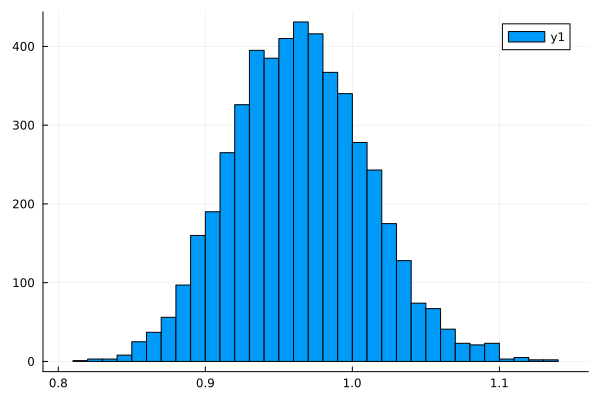

In [26]:
histogram(test[2])

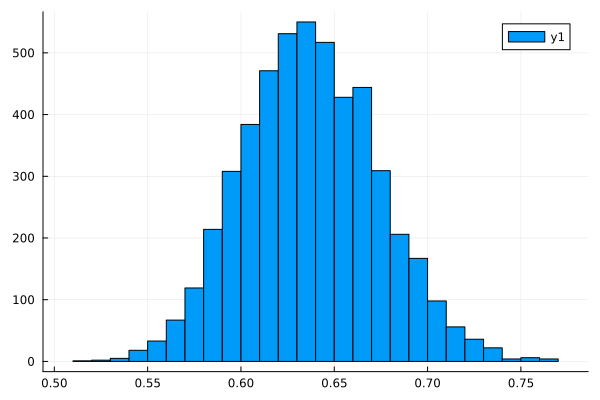

In [27]:
histogram(test[3])

## Can now see the bootstrapped stds for everything

In [28]:
bs1samp = bootstrap_samps(n_ints[1],c_ints[1],n_vols[1],Ns[1])
c1var = var(bs1samp[1]); ffn1var = var(bs1samp[2]); ffc1var = var(bs1samp[3]);
[c1var,ffn1var,ffc1var].^1/2

3-element Vector{Float64}:
 0.0038327127122864263
 0.002095013097897998
 0.0011322590151972766

In [29]:
bs2samp = bootstrap_samps(n_ints[2],c_ints[2],n_vols[2],Ns[2])
c2var = var(bs2samp[1]); ffn2var = var(bs2samp[2]); ffc2var = var(bs2samp[3]);
[c2var,ffn2var,ffc2var].^1/2

3-element Vector{Float64}:
 0.002475496424200744
 0.001915755675209527
 0.0014699431394119165

In [30]:
bs3samp = bootstrap_samps(n_ints[3],c_ints[3],n_vols[3],Ns[3])
c3var = var(bs3samp[1]); ffn3var = var(bs3samp[2]); ffc3var = var(bs3samp[3]);
[c3var,ffn3var,ffc3var].^1/2

3-element Vector{Float64}:
 0.0019830545675007067
 0.001042348405011056
 0.0006186530662015493

In [31]:
bs4samp = bootstrap_samps(n_ints[4],c_ints[4],n_vols[4],Ns[4])
c4var = var(bs4samp[1]); ffn4var = var(bs4samp[2]); ffc4var = var(bs4samp[3]);
[c4var,ffn4var,ffc4var].^1/2

3-element Vector{Float64}:
 0.0017705768660112938
 0.0018367479303938985
 0.0005673307548332065